<a href="https://colab.research.google.com/github/allisonfowle/ds4002jterm/blob/main/2ndDSWeek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Amazon Fashion Reviews to Predict Product Ratings
## Background
With the importance of ratings and reviews in consumer browsing and purchases, Amazon uses ML models to filter and accentuate particular reviews over others. This allows for optimal use to the consumer as well as improves user experience in navigating product details. Especially, after a case of false reviews, Amazon sued several operators for their deceptive violations in obtaining profits by interfering with product reviews and inflating ratings. Therefore, by using a ML model to filter, analyze and continuously update top reviews, the platform will be able to provide the most helpful and unbiased, prime user experience possible.

Additionally, Amazon Vine is a private program that selects a group of reviewers with free access to products in exchange for a verbal review of the product. Consumers are asked to voice their honest opinions - positive, neutral, or negative - of the product so that their review can be published under a 'Vine' label. This distinguishes their review for use to other consumers as well as to contribute to Amazon's AI algorithm in fashion recommendations.

## Question
Is there a strong correlation between the rating and the positive/negative relation of the reviews?

## Method
Our approach is to create a ML model that is capable of predicting product ratings based on the emotional implications of reviews (positive, negative, neutral types) using Semantic Analysis. Particularly, using TextBlob (formal text) and VADER (social media, punctuation, repetitive words, slang).

First, the data and metadata related to Amazon fashion was cleaned and filtered. Using TextBlob, polarity and subjectivity scores were identified for each review. Polarity, also known as sentiment score, refers to the overall sentiment of a text, word, or phrase and is displayed as being positive, neutral, or negative. Whereas Subjectivity refers to the removal of neutral (factual) text that has no contributing polarity to a sentence or phrase.

Due to the large data size, the first 100,000 reviews were arbitrarily selected for ease of testing purposes. Because the ~700,000 reviews is too large of a dataset to test within the span of a week, our group decided that 200,000 reviews was a representative result of the entire dataset for the scope of our project.

Ratings of each review were also taken into consideration to ensure that the semantic analysis were a reasonable match to the overall sentiment of the review. Where 4 or 5 star ratings implied a generally positive result, 3 stars is a neutral point, and 1 or 2 star ratings represented a generally negative range.

Next, our original intention was to implement VADER (via NLTK) to get polarity scores to compare against the TextBlob data, but found that VADER relied on a differing range and resulted in contrasting results. While TextBlob identifies positive/negative values based on a range from -1 to 1, VADER had a more precise range cutoff (-0.05> is negative, 0.35< is positive, neutral is the range between those bounds).
Interestingly, it was observed that the TextBlob had more accurately representive sentiment types relative to the VADER test, which research has indicated VADER to be more accurate - especially with informal text.

Cohen's Kappa is a statistical test done to determine the agreement between lists of comparable values. Therefore, we found Cohen's coefficient between the real to Textblob, real to VADER, and Textblob versus VADER results to see if the semantic types from the TextBlob and VADER methods would return accurately similar polarity types.
Furthermore, the accuracy in predicting the ratings was also measured via Cohen's Kappa. Where the predicted ratings based on the reviews from our model were compared to the direct ratings provided from the dataset.


# feedback
- how do we know pos/neg ?
- do we plan on using all 700,000?
- how is the dataset ordered? why choosing 100,000 entries?
- liked how we use 2 different models, using a smaller dataset was smart
- more clarification on what polarity/subjectivity means
- more potential limitations of VADER? with positive or negative or neutral
- how are we evaluating if it’s accurate or not
- package documentation of textblob/vader for more explanation 



In [2]:
### Import Packages and Data -----------------------------------------------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import time
#import sys
#!{sys.executable} -m pip install textblob
from textblob import TextBlob
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')        # nltk - VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import cohen_kappa_score

df = pd.read_csv("amazon_fashion.csv")
#785,452 rows
df_meta = pd.read_csv("amazon_fashion_meta.csv")
#186,637 rows

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
### Data Cleaning ----------------------------------------------------------------------------------------------------------------------------

# converting data types: data types are originially 'object'
df['overall'] = df['overall'].astype(str).astype(int)     # 'overall' = rating
df['reviewText'] = df['reviewText'].astype(str)           # 'reviewText' = review

#df meta todo: remove feature, rank?, 'date',  fit, details, similar_item, tech1
    # let's keep imageURL and try to see if we can use that in presentation
    # how many nan's in price?: 168,838
df_meta.drop(['feature', 'rank', 'date', 'fit', 'details', 'similar_item', 'tech1'], axis=1)
df_meta['price'].isna().sum()

print("DF dataframe NAN: ", df.isna().sum().sum())
print("DF meta dataframe NAN: ", df_meta.isna().sum().sum())

DF dataframe NAN:  1531410
DF meta dataframe NAN:  1592608


In [4]:
### TextBlob Functions ----------------------------------------------------------------------------------------------------------------------------------
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None
    
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None
    
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

def star_score(text):
    if text >= 4:
      return "Positive"
    elif text == 3:
      return "Neutral"
    else:
      return "Negative"

def sentiment_scores(sentence):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(sentence)
    
    # decide sentiment as positive, negative and neutral
    if sentiment['compound'] > 0.35 :
      return "Positive"
    elif sentiment['compound'] < -0.05 :
      return "Negative"
    else :
      return "Neutral"
 
#df_1 = df.loc[:10000]

# Splitting the data into smaller chunks to work with
starttime = time.time()
df_1 = df.loc[:200000]

df_1['Tsubjectivity'] = df_1['reviewText'].apply(subjectivity_calc)
df_1['Tpolarity'] = df_1['reviewText'].apply(polarity_calc)
df_1['Tanalysis'] = df_1['Tpolarity'].apply(getAnalysis)
df_1['Vanalysis'] = df_1['reviewText'].apply(sentiment_scores)
df_1['Stars'] = df_1['overall'].apply(star_score)

# print(df_1['Tsubjectivity'])
# print(df_1['Tpolarity'])
# print(df_1['Tanalysis'])


endtime = time.time()
totaltime = (endtime - starttime) / 60
print(totaltime)
### 200,000 - 133.5 sec
### 300,000 - 2.2 mins

<ipython-input-4-91961c926b0e>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Tsubjectivity'] = df_1['reviewText'].apply(subjectivity_calc)
<ipython-input-4-91961c926b0e>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Tpolarity'] = df_1['reviewText'].apply(polarity_calc)
<ipython-input-4-91961c926b0e>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

21.656937515735628


<ipython-input-4-91961c926b0e>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Vanalysis'] = df_1['reviewText'].apply(sentiment_scores)
<ipython-input-4-91961c926b0e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Stars'] = df_1['overall'].apply(star_score)


## Using Textblob and VADER


In [5]:
### Cohen's Kappa -------------------------------------------------------------------------------------------------
from sklearn.metrics import cohen_kappa_score

real = df_1['Stars']
tb = df_1['Tanalysis']
v = df_1['Vanalysis']

# if Textblob result is equal to the Real (star rating), return 1, else return 0
df_1['realVStext'] = np.where(real == tb, 1, 0)
# if VADER result is equal to the Real (star rating), return 1, else return 0
df_1['realVSvader'] = np.where(real == v, 1, 0)
# if Textblob result is equal to VADER result, return 1, else return 0
df_1['textVSvader'] = np.where(tb == v, 1, 0)

realVStext_list = df_1.realVStext.values.tolist()
realVSvader_list = df_1.realVSvader.values.tolist()
textVSvader_list = df_1.textVSvader.values.tolist()

#Compare Textblob/Real Results to VADER/Real results
cks = cohen_kappa_score(realVStext_list, realVSvader_list)
#Compare Textblob/Real Results to both VADER/Textblob
cks1 = cohen_kappa_score(realVStext_list, textVSvader_list)
#Compare VADER/Real results to both VADER/Textblob
cks2 = cohen_kappa_score(realVSvader_list, textVSvader_list)
print('Textblob vs VADER ', cks)
print('Textblob vs VADER&Textblob ', cks1)
print('VADER vs Vader&Textblob', cks2)

#print(df_1)

# df_1['Tsubjectivity'] = df_1['reviewText'].apply(subjectivity_calc)
# df_1['Tpolarity'] = df_1['reviewText'].apply(polarity_calc)
# df_1['Tanalysis'] = df_1['Tpolarity'].apply(getAnalysis)
# df_1['Vanalysis'] = df_1['reviewText'].apply(sentiment_scores)
# df_1['Stars'] = df_1['overall'].apply(star_score)

<ipython-input-5-6523b24f4bf8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['realVStext'] = np.where(real == tb, 1, 0)
<ipython-input-5-6523b24f4bf8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['realVSvader'] = np.where(real == v, 1, 0)
<ipython-input-5-6523b24f4bf8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Textblob vs VADER  0.5912683088560902
Textblob vs VADER&Textblob  0.4173633572544899
VADER vs Vader&Textblob 0.4188771899047048


## Cohen's Kappa Analysis
Our dataset included an 'overall' column, which was a star rating from one to five. As previously mentioned, we identified a star rating of 4 and above as 'Positive', 3 as "Neutral", and 2 and below as "Negative". We considered this column to be the 'real' star rating to compare Textblob and VADER analysis. 



```
real = df_1['Stars']
tb = df_1['Tanalysis']
v = df_1['Vanalysis']
```



We calculated three different types of Cohen's Kappa scores: comparing Textblob with the real results, comparing VADER with the real results, and then comparing Textblob and VADER. Cohen's Kappa is used to measure the level of agreement between two or more lists who each classify items into mutually exlusive categories. This means that we needed three lists of 0s and 1s, a 1 indicating that there was agreement between the star rating and the predicted, 0 indicating no agreement. Cohen's Kappa also attempts to account for the fact that agreement could be purely by chance. The closer the Cohen's Kappa score is to 1, the more agreement there is. 



```
# if Textblob result is equal to the Real (star rating), return 1, else return 0
df_1['realVStext'] = np.where(real == tb, 1, 0)
# if VADER result is equal to the Real (star rating), return 1, else return 0
df_1['realVSvader'] = np.where(real == v, 1, 0)
# if Textblob result is equal to VADER result, return 1, else return 0
df_1['textVSvader'] = np.where(tb == v, 1, 0)
```



We compared Textblob/Real results to VADER/Real results with a Cohen's Kappa score of 0.59. This means that both VADER and Textblob combined had a 59% agreement on predicting whether or not a review was "Positive", "Negative", or "Neutral". 


```
#Compare Textblob/Real Results to VADER/Real results
cks = cohen_kappa_score(realVStext_list, realVSvader_list)
print('Textblob vs VADER ', cks)
```



We compared Textblob/Real results to VADER/Textblob to see how accurate Textblob and VADER would be at predicting the type of review. The Cohen's Kappa score for this was 42%, meaning that Textblob agreed with less than half of both VADER and Textblob combined.

```
#Compare Textblob/Real Results to both VADER/Textblob
cks1 = cohen_kappa_score(realVStext_list, textVSvader_list)
print('Textblob vs VADER&Textblob ', cks1)
```

Lastly, we compared VADER/Real results to VADER/Textblob to see how accurate VADER results would be compared to VADER and Textblob combined. Surprisingly, the Cohen's Kappa score was also 42%.

```
#Compare VADER/Real results to both VADER/Textblob
cks2 = cohen_kappa_score(realVSvader_list, textVSvader_list)
print('VADER vs Vader&Textblob', cks2)
```

We can conclude that Textblob and VADER do not really agree with each other that much. It seems as though where Textblob had more groupings of one review (i.e. - more "Positive"), VADER had less (i.e. - less "Positive").

Using Cohen's Kappa, we can know that using Textblob OR VADER is the best way to predict an Amazon review rating instead of using both.


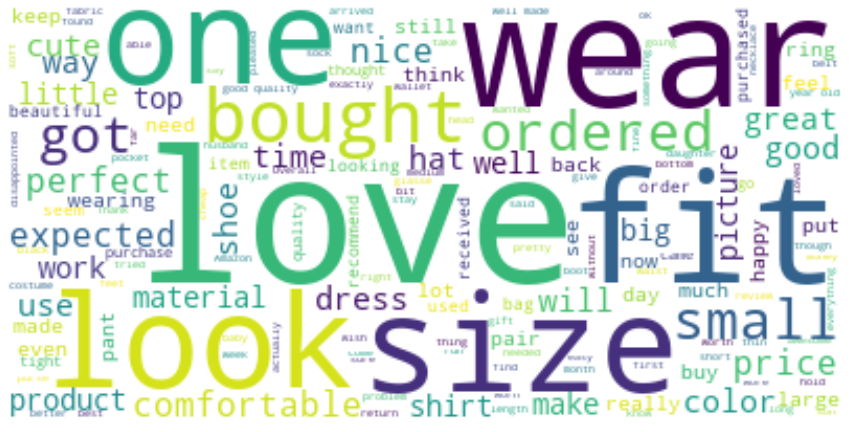

In [13]:
# Interactive Graphs
import plotly.graph_objects as px
import plotly.graph_objects as go
import plotly
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt


df_ten = df_1.loc[:10000]
df_three = df_1.loc[:300000]

ratings = ['Positive', 'Negative', 'Neutral']

fig1 = go.Figure(data=[
    go.Bar(name='Textblob', x=ratings, y=df_ten['Tanalysis'].value_counts()),
    go.Bar(name='Stars', x=ratings, y=df_ten['Stars'].value_counts()),
    go.Bar(name='VADER', x=ratings, y=df_ten['Vanalysis'].value_counts())
])
fig1.update_layout(title='Textblob Analysis vs VADER vs Star Type - 10,000 Rows',
                  xaxis_title = "Rating",
                  yaxis_title = "Count")


fig2 = go.Figure(data=[
    go.Bar(name='Textblob', x=ratings, y=df_three['Tanalysis'].value_counts()),
    go.Bar(name='Stars', x=ratings, y=df_three['Stars'].value_counts()),
    go.Bar(name='VADER', x=ratings, y=df_three['Vanalysis'].value_counts())

])
fig2.update_layout(title='Textblob Analysis vs VADER vs Star Type - 300,000 Rows',
                  xaxis_title = "Rating",
                  yaxis_title = "Count")

# Add dropdown
fig1.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["type", "bar"],
                    label="Bar Graph",
                    method="restyle"
                ),
                dict(
                    args=["type", "line"],
                    label="Line Graph",
                    method="restyle"
                )
            ]),
        ),
    ]
)

fig2.update_layout(
    updatemenus=[
        dict(
            buttons=list([
                dict(
                    args=["type", "bar"],
                    label="Bar Graph",
                    method="restyle"
                ),
                dict(
                    args=["type", "word"],
                    label="Line Graph",
                    method="restyle"
                )
            ]),
        ),
    ]
)
fig1.show()
fig2.show()


text = " ".join(i for i in df_1['reviewText'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# Conclusion
Based on the polarity results and Cohen's Kappa, the predicted ratings of our model displayed a XXX% accuracy relative to the actual ratings...

## Limitations & Future Work

*   The original dataset contained nearly 700,000 reviews of various products. Further testing of our model could be done by expanding the number of reviews analyzed.
*   Use of the metadata - particularly to divide the reviews based on fashion product type/form could have cleaned the data and given more context of the review.
*   Incorporation of the 'upvote' feature. While provided as an attribute in the dataset, the column was mostly empty. However, using this factor could eventually be used to determine Top Reviews that are indicated to be the most helpful to other consumers.
*   List item


### Sources


*   https://retailwire.com/discussion/amazon-uses-artificial-intelligence-to-improve-review-rating-system/ 
*   https://www.amazon.com/vine/about 
*   https://towardsdatascience.com/7-nlp-techniques-you-can-easily-implement-with-python-dc0ade1a53c2 
*   https://pub.towardsai.net/textblob-vs-vader-for-sentiment-analysis-using-python-76883d40f9ae 
*   https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524 
*   List item






